In [1]:
import sys

sys.path.append("..")
from src import metrics
from src import constant
from src.utils import get_device, set_seed, haversine
from src.datasets.mp16 import MP16Dataset, collate_fn
from torch.utils.data import DataLoader
from tqdm import tqdm
import polars as pl
from src.pipeline.feature_extractor import FeatureExtractor
import numpy as np

/home/affahrizain/project/s4-landmark-ir/notebooks/../AlphaCLIP/alpha_clip/alpha_clip.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging


In [2]:
set_seed(42)
device = get_device()

In [23]:
# extractor = FeatureExtractor()
from functools import partial
from transformers import AutoModel, AutoProcessor

def clip_collate_fn(processor, batch):
    images = [b["image"] for b in batch]
    inputs = processor(images=images, return_tensors="pt")
    return inputs


clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
clip_model = AutoModel.from_pretrained("openai/clip-vit-large-patch14").to(device).eval()

df_ref = pl.read_csv("../datasets/mp16-reason-train-annot.csv")
df_test = pl.read_csv("../datasets/mp16-reason-test-annot.csv")
dataset = MP16Dataset(
    df_test,
    img_col="IMG_ID",
    img_base_path="../datasets/mp16-reason",
)
loader = DataLoader(
    dataset,
    batch_size=128,
    collate_fn=partial(clip_collate_fn, clip_processor),
)

Loading weights:   0%|          | 0/590 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-large-patch14
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [4]:
import torch

embeddings = []
with torch.no_grad():
    for batch in tqdm(loader, desc="encode"):
        out = clip_model.get_image_features(
            **{k: v.to(device) for k, v in batch.items()}
        )
        out = out.pooler_output.cpu()
        embeddings.append(out)
embeddings = torch.vstack(embeddings).numpy()

encode: 100%|██████████| 94/94 [01:52<00:00,  1.19s/it]


In [5]:
from src.utils import read_index

index, meta = read_index("../index/clip")
meta = meta["metadata"]

In [6]:
index.hnsw.efSearch = 128

In [7]:
import pandas as pd
import faiss

all_ref_gps = []
all_metas = {}
gt_gps = df_test.select("LAT", "LON").to_numpy().tolist()
for ix in tqdm(range(len(df_test)), desc="sim search"):
    query_emb = embeddings[ix].astype("float32").reshape(1, -1)
    faiss.normalize_L2(query_emb)
    sim, ind = index.search(query_emb, 100)
    flat_D, flat_I = sim.reshape(-1), ind.reshape(-1)
    # if ix == 4285:
    #     break
    sorted_sim_ids = (
        pd.DataFrame({"idx": flat_I, "score": flat_D})
        .sort_values(by="score", ascending=False)
        .drop_duplicates(subset="idx")
        .idx.tolist()
    )
    sim_meta = [meta[ii] for ii in sorted_sim_ids][:100]
    all_metas[ix] = sim_meta
    ref_gps = [[item["LAT"], item["LON"]] for item in sim_meta]
    all_ref_gps.append(ref_gps)

sim search: 100%|██████████| 12000/12000 [00:11<00:00, 1047.39it/s]


In [8]:
def haversine_np(gps1: list | tuple | np.ndarray, gps2: list | tuple | np.ndarray):
    if not isinstance(gps1, np.ndarray):
        gps1 = np.array(gps1)
    if not isinstance(gps2, np.ndarray):
        gps2 = np.array(gps2)

    gps1 = np.atleast_2d(gps1)
    gps2 = np.atleast_2d(gps2)

    lat1, lon1 = np.radians(gps1).T
    lat2, lon2 = np.radians(gps2).T

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    dist = 6371 * c
    if dist.size == 1:
        return dist.item()
    return dist


def precision_k(
    gt_gps: np.ndarray, ret_gps: np.ndarray, k: int = 10, min_dist: int = 50
):
    """Out of the top-K results, how many are actually outside the forbidden radius?"""
    distances = haversine_np(gt_gps, ret_gps).T
    return np.mean(distances[:, :k] >= min_dist)

In [9]:
metrics = {
    "precision@10": precision_k(gt_gps, all_ref_gps, k=10, min_dist=250).item(),
    "precision@100": precision_k(gt_gps, all_ref_gps, k=100, min_dist=250).item(),
}

metrics

{'precision@10': 0.574975, 'precision@100': 0.6612416666666666}

In [ ]:
import json

with open("clip_retrieval_meta.json", "w") as f:
    f.write(json.dumps(all_metas))

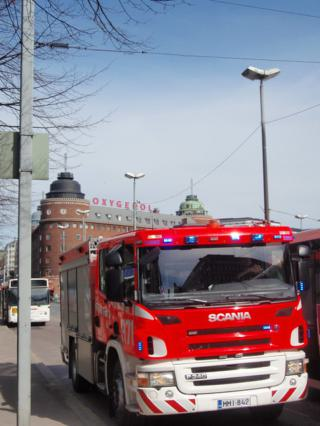

In [22]:
from PIL import Image
import os

Image.open(os.path.join("../datasets/mp16-reason/", df_test.item(0, "IMG_ID")))